In [1]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.io as tvio
import matplotlib.pyplot as plt

In [2]:
# Ignore this - used so that matplotlib works.
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
# Creating a image dataset class for custom dataset.
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform = None):
        self.root_dir = root_dir
        self.transform = transform
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(self._find_classes(root_dir))}
        self.samples = self._make_dataset(root_dir)
        self.classes = list(self.class_to_idx.keys())  # Define the classes attribute

    def __getitem__(self, idx):
        img_path, class_name = self.samples[idx]
        image = self.read_image_as_tensor(img_path) 
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        return image, self.class_to_idx[class_name]  # Return the index of the class - tensors cannot be string.

    def _make_dataset(self, directory):
        images = []
        for target_class in self.class_to_idx.keys():
            target_dir = os.path.join(directory, target_class)
            if not os.path.isdir(target_dir):
                continue
            for root, _, fnames in sorted(os.walk(target_dir)):
                for fname in sorted(fnames):
                    path = os.path.join(root, fname)
                    item = (path, target_class)  
                    images.append(item)
        return images
        
    def read_image_as_tensor(self, img_path):
        image = tvio.read_image(img_path)
        if image.shape[0] == 4:  # PNG image sometimes has 4 channels.
            image = image[:3, :, :]  # Keep only the first 3 channels
        return image
    
    def _find_classes(self, directory):
        classes = [d.name for d in os.scandir(directory) if d.is_dir()]  # Each subfolder name is the class label.
        classes.sort()
        return classes
    
    def __len__(self):
        return len(self.samples)
    
    def __add__(self, other):
        concatenated_samples = self.samples + other.samples
        concatenated_classes = self.classes + other.classes
        concatenated_class_to_idx = {class_name: idx for idx, class_name in enumerate(concatenated_classes)}
        concatenated_dataset = CustomImageDataset.__new__(CustomImageDataset)
        concatenated_dataset.root_dir = self.root_dir  
        concatenated_dataset.transform = self.transform
        concatenated_dataset.samples = concatenated_samples
        concatenated_dataset.classes = concatenated_classes
        concatenated_dataset.class_to_idx = concatenated_class_to_idx
        return concatenated_dataset

In [4]:
# Defining transform with some data agumentation
aug_trans = transforms.Compose([
    transforms.RandomHorizontalFlip(),  
    transforms.RandomVerticalFlip(),  
    transforms.ColorJitter(brightness = 0.1, contrast = 0.1, saturation = 0.1, hue = 0.1),  
    transforms.RandomRotation(10),  
    transforms.Lambda(lambda x: x / 255.),  # Scale to 0, 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
    transforms.Resize((64, 64))
])

trans = transforms.Compose([
    transforms.Lambda(lambda x: x / 255.),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
    transforms.Resize((64, 64))
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


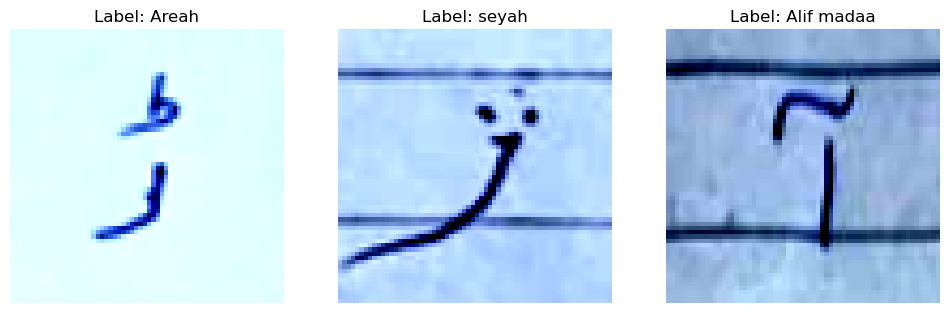

Number of samples = 3104


In [5]:
# Checking to see if dataset is properly read in.
image_folder = 'DL Cep Data'

normal = CustomImageDataset(root_dir = image_folder, transform = trans)
aug_dataset = CustomImageDataset(root_dir = image_folder, transform = aug_trans)

custom_dataset = normal + aug_dataset 
dataloader = DataLoader(custom_dataset, batch_size = 4, shuffle = True)

for images, labels in dataloader:
    images_np = images.permute(0, 2, 3, 1).numpy() 
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    for i in range(3):
        class_index = labels[i].item() 
        class_name = custom_dataset.classes[class_index]  
        axes[i].imshow(images_np[i])
        axes[i].set_title(f"Label: {class_name}") 
        axes[i].axis('off')
    plt.show()
    break

print(f"Number of samples = {len(custom_dataset)}")

In [6]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

In [7]:
# Defining the test, load and validation datasets.
from torch.utils.data import random_split

train_size = int(0.7 * len(custom_dataset))  # 70% 
val_size = int(0.2 * len(custom_dataset))    # 20% 
test_size = len(custom_dataset) - train_size - val_size  # 10%

train_dataset, val_dataset, test_dataset = random_split(custom_dataset, [train_size, val_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle = True) # 32
val_dataloader = DataLoader(val_dataset, batch_size = 32, shuffle = False)
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle = False)


In [8]:
class VGG16(nn.Module):
    def __init__(self, num_classes = 39):
        super(VGG16, self).__init__()
        self.b1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.b2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2))  # Input image size = 64 x 64, now (32 x 32)
        self.b3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.b4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) # (16 x 16)
        self.b5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.b6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.b7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) # (8 x 8)
        self.b8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.b9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.b10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) # (4 x 4)
        self.b11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.b12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.b13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) # (2 x 2)
        self.d1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512 * 2 * 2, 1205),  # (channels x h x w)
            nn.ReLU())
        self.d2 = nn.Sequential(  
            nn.Dropout(0.5),
            nn.Linear(1205, 1205),
            nn.ReLU())
        self.d3 = nn.Sequential(
            nn.Linear(1205, num_classes))

    def forward(self, x):
        out = self.b1(x)
        out = self.b2(out)
        out = self.b3(out)
        out = self.b4(out)
        out = self.b5(out)
        out = self.b6(out)
        out = self.b7(out)
        out = self.b8(out)
        out = self.b9(out)
        out = self.b10(out)
        out = self.b11(out)
        out = self.b12(out)
        out = self.b13(out)
        out = out.view(out.size(0), -1)  
        out = self.d1(out)
        out = self.d2(out)
        out = self.d3(out)
        return out


In [9]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.l1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))  # input size = 64 x 64
        self.l2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.l3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.l4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.l5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))  
        self.d1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 2 * 2, 1205),
            nn.ReLU())
        self.d2 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1205, 1205),
            nn.ReLU())
        self.d3= nn.Sequential(
            nn.Linear(1205, num_classes))
        
    def forward(self, x):
        out = self.l1(x)
        out = self.l2(out)
        out = self.l3(out)
        out = self.l4(out)
        out = self.l5(out)
        out = out.view(out.size(0), -1)  
        out = self.d1(out)
        out = self.d2(out)
        out = self.d3(out)
        return out


In [10]:
# Training
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # use gpu for faster training.

model_1 = VGG16(num_classes = len(custom_dataset.classes)).to(device)  
model_2 = AlexNet(num_classes = len(custom_dataset.classes)).to(device)  

for model in [model_1, model_2]:
    print(f"Training {model.__class__.__name__}")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.005, weight_decay = 0.005, momentum = 0.9)  

    model.train()

    for epoch in range(17):
        running_loss = 0.0
        for images, labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1}", unit="batch"):

            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Training Loss: {running_loss / len(train_dataloader)}")

        # Validation
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_dataloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        avg_val_loss = test_loss / len(test_dataloader)
        accuracy = 100 * correct / total
        print(f'Validation Loss: {avg_val_loss}')
        print(f'Accuracy: {accuracy}%')
        model.train()
    print('Finished Training')


Training VGG16


Epoch 1: 100%|██████████████████████████████████████████████████████████████████████| 68/68 [01:34<00:00,  1.39s/batch]


Training Loss: 3.6755891827976
Validation Loss: 6.621187925338745
Accuracy: 6.290322580645161%


Epoch 2: 100%|██████████████████████████████████████████████████████████████████████| 68/68 [01:39<00:00,  1.46s/batch]


Training Loss: 2.2880402032066796
Validation Loss: 4.598638415336609
Accuracy: 26.129032258064516%


Epoch 3: 100%|██████████████████████████████████████████████████████████████████████| 68/68 [01:34<00:00,  1.39s/batch]


Training Loss: 1.4656057725934422
Validation Loss: 2.4172499418258666
Accuracy: 55.806451612903224%


Epoch 4: 100%|██████████████████████████████████████████████████████████████████████| 68/68 [01:39<00:00,  1.46s/batch]


Training Loss: 1.0036867374882978
Validation Loss: 2.0107131779193876
Accuracy: 63.70967741935484%


Epoch 5: 100%|██████████████████████████████████████████████████████████████████████| 68/68 [01:38<00:00,  1.45s/batch]


Training Loss: 0.6542504320249838
Validation Loss: 2.6872166216373445
Accuracy: 57.41935483870968%


Epoch 6: 100%|██████████████████████████████████████████████████████████████████████| 68/68 [01:34<00:00,  1.39s/batch]


Training Loss: 0.4521445605684729
Validation Loss: 1.2400652304291726
Accuracy: 79.51612903225806%


Epoch 7: 100%|██████████████████████████████████████████████████████████████████████| 68/68 [01:31<00:00,  1.35s/batch]


Training Loss: 0.38564454325858283
Validation Loss: 1.1883517786860467
Accuracy: 80.80645161290323%


Epoch 8: 100%|██████████████████████████████████████████████████████████████████████| 68/68 [01:32<00:00,  1.36s/batch]


Training Loss: 0.2576578690615647
Validation Loss: 0.5038340061902999
Accuracy: 91.45161290322581%


Epoch 9: 100%|██████████████████████████████████████████████████████████████████████| 68/68 [01:32<00:00,  1.37s/batch]


Training Loss: 0.17032261494108858
Validation Loss: 0.5853418115526438
Accuracy: 91.93548387096774%


Epoch 10: 100%|█████████████████████████████████████████████████████████████████████| 68/68 [01:32<00:00,  1.36s/batch]


Training Loss: 0.13245898016783245
Validation Loss: 0.9982215307652951
Accuracy: 85.96774193548387%


Epoch 11: 100%|█████████████████████████████████████████████████████████████████████| 68/68 [01:33<00:00,  1.37s/batch]


Training Loss: 0.1305274371715153
Validation Loss: 0.3475488257594407
Accuracy: 95.3225806451613%


Epoch 12: 100%|█████████████████████████████████████████████████████████████████████| 68/68 [01:31<00:00,  1.35s/batch]


Training Loss: 0.07136058034923147
Validation Loss: 0.45970072615891694
Accuracy: 91.7741935483871%


Epoch 13: 100%|█████████████████████████████████████████████████████████████████████| 68/68 [01:32<00:00,  1.36s/batch]


Training Loss: 0.050388409413726014
Validation Loss: 0.6359704166650773
Accuracy: 88.2258064516129%


Epoch 14: 100%|█████████████████████████████████████████████████████████████████████| 68/68 [01:31<00:00,  1.35s/batch]


Training Loss: 0.06677513716139775
Validation Loss: 0.354988057538867
Accuracy: 94.83870967741936%


Epoch 15: 100%|█████████████████████████████████████████████████████████████████████| 68/68 [01:33<00:00,  1.37s/batch]


Training Loss: 0.05723921892315369
Validation Loss: 0.18628347939811646
Accuracy: 96.93548387096774%


Epoch 16: 100%|█████████████████████████████████████████████████████████████████████| 68/68 [01:30<00:00,  1.34s/batch]


Training Loss: 0.08909969752216164
Validation Loss: 0.2282536835409701
Accuracy: 96.61290322580645%


Epoch 17: 100%|█████████████████████████████████████████████████████████████████████| 68/68 [01:33<00:00,  1.37s/batch]


Training Loss: 0.021777843539466095
Validation Loss: 0.27154952646233144
Accuracy: 95.64516129032258%
Finished Training
Training AlexNet


Epoch 1: 100%|██████████████████████████████████████████████████████████████████████| 68/68 [00:07<00:00,  9.09batch/s]


Training Loss: 3.655086881974164
Validation Loss: 5.35965850353241
Accuracy: 14.838709677419354%


Epoch 2: 100%|██████████████████████████████████████████████████████████████████████| 68/68 [00:07<00:00,  9.38batch/s]


Training Loss: 2.204470538041171
Validation Loss: 5.47294590473175
Accuracy: 20.0%


Epoch 3: 100%|██████████████████████████████████████████████████████████████████████| 68/68 [00:07<00:00,  9.60batch/s]


Training Loss: 1.4913424691733193
Validation Loss: 2.682140499353409
Accuracy: 51.45161290322581%


Epoch 4: 100%|██████████████████████████████████████████████████████████████████████| 68/68 [00:07<00:00,  9.13batch/s]


Training Loss: 1.0610136118005304
Validation Loss: 2.2222863376140594
Accuracy: 59.354838709677416%


Epoch 5: 100%|██████████████████████████████████████████████████████████████████████| 68/68 [00:07<00:00,  9.29batch/s]


Training Loss: 0.8100792121361283
Validation Loss: 1.9341334104537964
Accuracy: 62.58064516129032%


Epoch 6: 100%|██████████████████████████████████████████████████████████████████████| 68/68 [00:07<00:00,  9.07batch/s]


Training Loss: 0.5761708823197028
Validation Loss: 1.6662692368030547
Accuracy: 68.87096774193549%


Epoch 7: 100%|██████████████████████████████████████████████████████████████████████| 68/68 [00:07<00:00,  9.23batch/s]


Training Loss: 0.5075546191895709
Validation Loss: 2.8875400900840758
Accuracy: 54.67741935483871%


Epoch 8: 100%|██████████████████████████████████████████████████████████████████████| 68/68 [00:07<00:00,  9.13batch/s]


Training Loss: 0.39868848946164637
Validation Loss: 1.3597509115934372
Accuracy: 78.06451612903226%


Epoch 9: 100%|██████████████████████████████████████████████████████████████████████| 68/68 [00:07<00:00,  9.11batch/s]


Training Loss: 0.27892622285906005
Validation Loss: 2.614557868242264
Accuracy: 63.87096774193548%


Epoch 10: 100%|█████████████████████████████████████████████████████████████████████| 68/68 [00:07<00:00,  9.15batch/s]


Training Loss: 0.26665186328703866
Validation Loss: 0.678156578540802
Accuracy: 87.25806451612904%


Epoch 11: 100%|█████████████████████████████████████████████████████████████████████| 68/68 [00:07<00:00,  8.87batch/s]


Training Loss: 0.21284876856952906
Validation Loss: 1.2851875483989716
Accuracy: 82.74193548387096%


Epoch 12: 100%|█████████████████████████████████████████████████████████████████████| 68/68 [00:07<00:00,  8.80batch/s]


Training Loss: 0.20357824582606554
Validation Loss: 1.783617526292801
Accuracy: 72.74193548387096%


Epoch 13: 100%|█████████████████████████████████████████████████████████████████████| 68/68 [00:07<00:00,  8.87batch/s]


Training Loss: 0.15712360681637244
Validation Loss: 1.341350081562996
Accuracy: 79.19354838709677%


Epoch 14: 100%|█████████████████████████████████████████████████████████████████████| 68/68 [00:07<00:00,  8.77batch/s]


Training Loss: 0.1179612094317289
Validation Loss: 0.9587168380618095
Accuracy: 88.06451612903226%


Epoch 15: 100%|█████████████████████████████████████████████████████████████████████| 68/68 [00:08<00:00,  8.49batch/s]


Training Loss: 0.09455254102837951
Validation Loss: 1.0552399091422557
Accuracy: 82.58064516129032%


Epoch 16: 100%|█████████████████████████████████████████████████████████████████████| 68/68 [00:07<00:00,  8.53batch/s]


Training Loss: 0.09922505339936298
Validation Loss: 0.6726743616163731
Accuracy: 90.48387096774194%


Epoch 17: 100%|█████████████████████████████████████████████████████████████████████| 68/68 [00:07<00:00,  8.59batch/s]


Training Loss: 0.06377233429948855
Validation Loss: 1.148385874927044
Accuracy: 84.19354838709677%
Finished Training


In [11]:
# Getting memory used.
from torchsummary import summary

summary(model_1, input_size = (3, 64, 64))  
summary(model_2, input_size = (3, 64, 64))  

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          36,928
       BatchNorm2d-5           [-1, 64, 64, 64]             128
              ReLU-6           [-1, 64, 64, 64]               0
         MaxPool2d-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]          73,856
       BatchNorm2d-9          [-1, 128, 32, 32]             256
             ReLU-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 128, 32, 32]         147,584
      BatchNorm2d-12          [-1, 128, 32, 32]             256
             ReLU-13          [-1, 128, 32, 32]               0
        MaxPool2d-14          [-1, 128,

In [16]:
# Testing 
from tabulate import tabulate
from sklearn.metrics import f1_score

results = []

for model, mem in zip([model_1, model_2], [97.86, 26.01]):
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    predictions = []
    targets = []

    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total_test += labels.size(0)
            correct_test += predicted.eq(labels).sum().item()
            predictions.extend(predicted.cpu().numpy())
            targets.extend(labels.cpu().numpy())

    avg_test_loss = test_loss / len(test_dataloader)
    test_accuracy = 100 * correct_test / total_test
    f1 = f1_score(targets, predictions, average='macro')  

    results.append([model.__class__.__name__, avg_test_loss, test_accuracy, f1, mem])

headers = ["Model", "Test Loss", "Test Accuracy", "F1 Score", "Memory (MB)"]
print(tabulate(results, headers=headers, tablefmt="grid"))

+---------+-------------+-----------------+------------+---------------+
| Model   |   Test Loss |   Test Accuracy |   F1 Score |   Memory (MB) |
+=========+=============+=================+============+===============+
| VGG16   |    0.145842 |         96.1538 |   0.96358  |         97.86 |
+---------+-------------+-----------------+------------+---------------+
| AlexNet |    0.379283 |         90.7051 |   0.905666 |         26.01 |
+---------+-------------+-----------------+------------+---------------+
